#  ARMA learning and prediction with a Kalman filter

In [1]:
import ssm

In [2]:
import pandas as pd
import numpy as np

/var/folders/vf/3b13gs616172kztlr53t6_s00000gn/T/ipykernel_8772/2162656668.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
import jax
import chex
import einops
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from jax.scipy.linalg import block_diag

In [4]:
%config InlineBackend.figure_format = "retina"

sns.set_palette("colorblind")
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
# plt.rcParams["figure.figsize"] = (7.2, 4.0)
plt.rcParams["figure.figsize"] = (7.2, 3.0)

jnp.set_printoptions(linewidth=200)

In [5]:
plt.rcParams["text.usetex"] = True

In [6]:
%load_ext autoreload
%autoreload 2

## The Kalman filter and predictions

In [7]:
@partial(jax.jit, static_argnames=("k",))
def forecast_mean(F, mu, k):
    """
    Following Proposition 2.2 in F.02
    """
    def _step(mu, _):
        mu_next = F @ mu
        return mu_next, mu_next
    steps = jnp.arange(k)
    _, mu_pred = jax.lax.scan(_step, mu, steps)
    return mu_pred


@partial(jax.jit, static_argnames=("k",))
def forecast_cov(F, Sigma, Q, k):
    """
    Following Proposition 2.3 in F.02
    """
    def _step(state, _):
        Sigma_mult, dynamics_carry, F_mult = state

        dynamics_carry = dynamics_carry + F_mult @ Q @ F_mult.T
        F_mult = F @ F_mult        
        Sigma_mult = F @ Sigma_mult @ F.T

        Sigma_pred = Sigma_mult + dynamics_carry
        
        state_next = (Sigma_mult, dynamics_carry, F_mult)
        return state_next, Sigma_pred
    steps = jnp.arange(k)
    dim_state = len(Q)
    state_init = (Sigma, jnp.zeros((dim_state, dim_state)), F)
    _, Sigma_pred = jax.lax.scan(_step, state_init, steps)
    return Sigma_pred

In [8]:
def kf_step_optimal(bel, y, H, F, R, Q, n_forecast):
    mu, Sigma = bel

    # Predict
    mu_pred = F @ mu
    Sigma_pred = F @ Sigma @ F.T + Q

    # innovation
    S = H @ Sigma_pred @ H.T + R
    K = jnp.linalg.solve(S, H @ Sigma_pred).T
    err =  y - H @ mu_pred # innovation

    # Update
    mu_update = mu_pred + K @ err
    Sigma_update = Sigma_pred - K @ S @ K.T
    bel_next = (mu_update, Sigma_update)

    mu_forecast = jnp.concat([mu_update[None, :], forecast_mean(F, mu_update, n_forecast)])
    y_forecast = jnp.einsum("...m,sm->...s", H, mu_forecast)
    out = {
        "mu": mu_update,
        "err": err,
        "yhat": H @ mu_pred,
        "y_corrected": H @ mu_update,
        "y_forecast": y_forecast,
    }

    return bel_next, out

## Defining the ARMA process

In [9]:
key = jax.random.PRNGKey(3141)
key_sample, key_train = jax.random.split(key)

In [10]:
ma_n = 10
H_ma = jnp.ones(10) * 1.
H_ar = jnp.ones(3) * jnp.zeros(3).at[0].set(0.8)
H, F, T = ssm.init_arma_components(H_ma=H_ma)
dim_state = len(H)
# R = jnp.eye(1) * 1.0 ** 2
R = jnp.eye(1) * 1.0 ** 2

In [11]:
n_steps = 200
n_test = 20
steps = jnp.arange(n_steps)
sample = ssm.sample_ssm(key_sample, F, H, T, R, n_steps + n_test)

test = jax.tree.map(lambda x: x[-n_test:], sample)
sample = jax.tree.map(lambda x: x[:-n_test], sample)

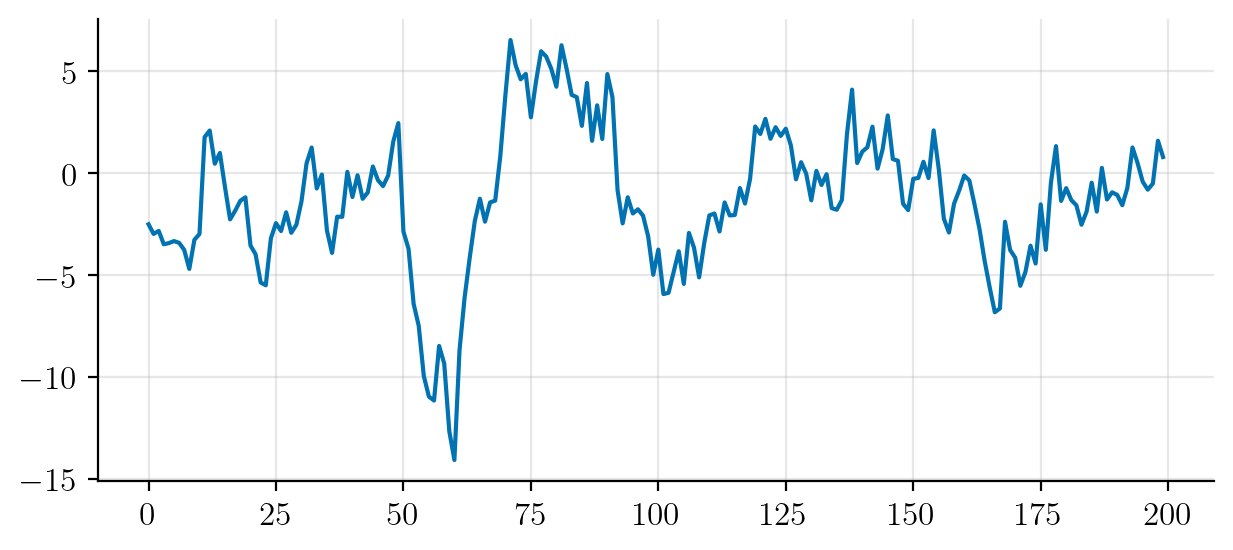

In [12]:
plt.plot(sample["y"])
plt.grid(alpha=0.3)

## Optimal filtering

In [13]:
Q = T @ R @ T.T
n_forecast = 12
_step = partial(kf_step_optimal, H=H[None, :], F=F, R=R, Q=Q, n_forecast=n_forecast)
y = sample["y"]

mu_init = jnp.zeros(dim_state)
Sigma_init = jnp.eye(dim_state)
bel_init = (mu_init, Sigma_init)

(mu, Sigma), hist_optimal = jax.lax.scan(_step, bel_init, y[:, None])
hist_optimal = jax.tree.map(jnp.squeeze, hist_optimal)

In [14]:
jnp.sqrt(jnp.power(hist_optimal["err"], 2).mean())

Array(1.6525016, dtype=float32)

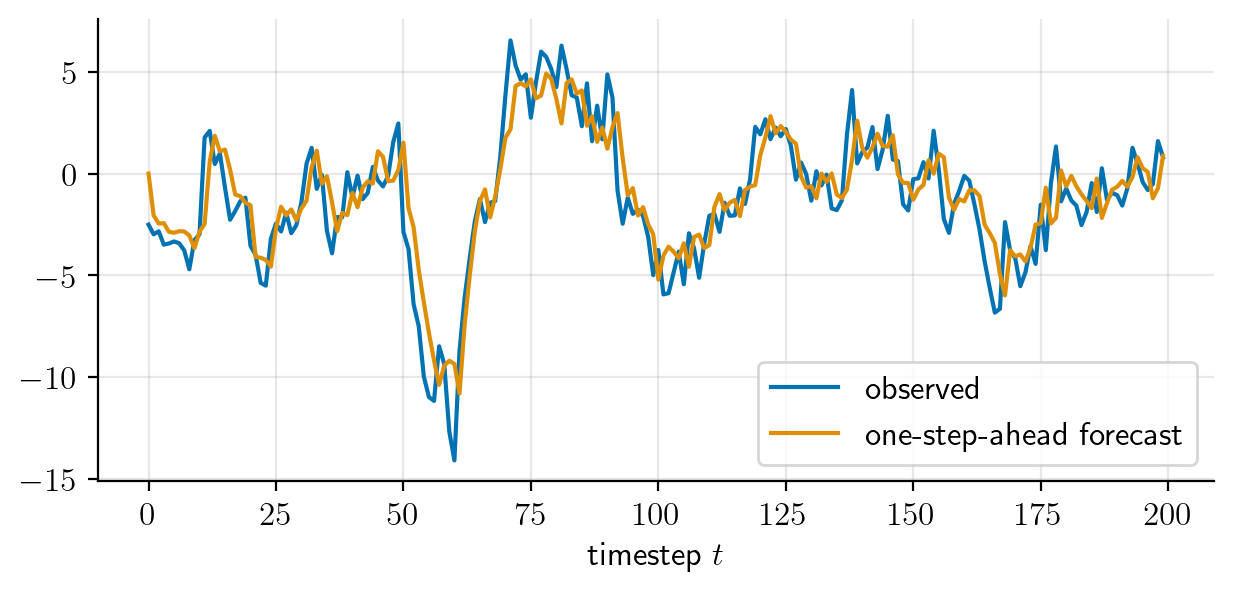

In [15]:
markersize = 0
plt.plot(sample["y"], marker="o", markersize=markersize, label="observed")
plt.plot(hist_optimal["yhat"], marker="o", markersize=markersize, label="one-step-ahead forecast")
plt.legend()
plt.xlabel("timestep $t$")
plt.grid(alpha=0.3)

## Learning and filtering

In [16]:
@chex.dataclass
class SSMConfig:
    """
    Known components of the SSM
    """
    F: jax.Array
    R: jax.Array
    Q: jax.Array
    latent_dim: jax.Array

@chex.dataclass
class KFState:
    mean: jax.Array
    cov: jax.Array
    dim: int

    @staticmethod
    def init(key, dim, cov_coeff, cov_latent):
        key_latent, key_coeff = jax.random.split(key)
        mean_latent = jax.random.normal(key_latent, (dim,)) * jnp.sqrt(cov_latent)
        mean_coeff = jax.random.normal(key_coeff, (dim,)) * jnp.sqrt(cov_coeff)
        mean_init = jnp.concat([mean_coeff, mean_latent])
        
        cov_coeff_init = jnp.eye(dim) * cov_coeff
        cov_latent_init = jnp.eye(dim) * cov_latent
        cov_init = jnp.zeros((2 * dim, 2 * dim))
        cov_init = cov_init.at[:dim, :dim].set(cov_coeff_init)
        cov_init = cov_init.at[dim:, dim:].set(cov_latent_init)
        
        return KFState(mean=mean_init, cov=cov_init, dim=dim)

    def mean_coeff(self, dim):
        return jax.lax.dynamic_slice_in_dim(self.mean, 0, dim)
        # return self.mean[:self.dim]

    def mean_latent(self, dim):
        return jax.lax.dynamic_slice_in_dim(self.mean, dim, dim)
        # return self.mean[self.dim:]

    def build_feature_and_bias(self, dim):
        """
        Obtain feature matrix and bias term for the online AR
        """
        mean_latent = self.mean_latent(dim)
        mean_coeff = self.mean_coeff(dim)
        # Estimated coefficient matrix
        H = jnp.r_[mean_latent, mean_coeff][None, :]
        bias = -mean_coeff.T @ mean_latent
        return H, bias

    
    def build_feature(self, dim):
        mean_latent = self.mean_latent(dim)
        mean_coeff = self.mean_coeff(dim)
        H = jnp.r_[mean_latent, mean_coeff][None, :]
        return H

    
    def predict(self, bel_pred, dim):
        """
        Predict next observation given mean vector
        """
        # H, bias = self.build_feature_and_bias(dim)
        # yhat = H @ mean + bias
        vcoeff = bel_pred.mean_coeff(dim)
        vlatent = bel_pred.mean_latent(dim)
        
        mean_latent = self.mean_latent(dim)
        mean_coeff = self.mean_coeff(dim)
        
        yhat = mean_coeff.T @ mean_latent + mean_coeff.T @ (vlatent - mean_latent) + mean_latent.T @ (vcoeff - mean_coeff)
        
        
        return yhat

In [17]:
def kf_step_inner(bel, bel_pred, y, ssm):
    """
    Inner iteration of the Iterated Kalman Filter
    """
    mu_pred = bel_pred.mean
    Sigma_pred = bel_pred.cov

    # H, bias = bel.build_feature_and_bias(ssm.latent_dim)
    # yhat = H @ mu_pred + bias
    
    H = bel.build_feature(ssm.latent_dim)
    yhat = bel.predict(bel_pred, ssm.latent_dim)

    # innovation
    S = H @ Sigma_pred @ H.T + ssm.R
    K = jnp.linalg.solve(S, H @ Sigma_pred).T
    err =  y - yhat

    # Update
    mu_update = mu_pred + K @ err
    Sigma_update = Sigma_pred - K @ S @ K.T
    
    bel = bel.replace(
        mean=mu_update,
        cov=Sigma_update
    )
    return bel


def kf_step_lin(bel, y, ssm, n_inner=1):
    """
    Iterated Kalman filter
    """
    # Predict
    mu_pred = ssm.F @ bel.mean
    Sigma_pred = ssm.F @ bel.cov @ ssm.F.T + Q

    bel_pred = bel.replace(
        mean=mu_pred,
        cov=Sigma_pred
    )

    _inner = lambda _, bel: kf_step_inner(bel, bel_pred, y, ssm)
    bel = jax.lax.fori_loop(0, n_inner, _inner, bel_pred)

    mean_latent = bel.mean_latent(ssm.latent_dim)
    H_est = bel.mean_coeff(ssm.latent_dim)
    mu_forecast = jnp.concat([mean_latent[None, :], forecast_mean(F, mean_latent, n_forecast)])
    y_forecast = jnp.einsum("...m,sm->...s", H_est, mu_forecast)
    out = {
        "mu": bel.mean,
        "yhat": bel_pred.predict(bel_pred, ssm.latent_dim),
        "y_corrected": H_est @ mean_latent,
        "y_forecast": y_forecast,
    }

    return bel, out

## Filter!

In [18]:
y = sample["y"]

In [19]:
state = KFState.init(key_train, dim=ma_n, cov_coeff=1.0, cov_latent=1.0)

In [20]:
%%time

A = block_diag(jnp.eye(ma_n), F)
Q = block_diag(jnp.eye(ma_n) * 0.1, T @ R @ T.T)

ssm_cfg = SSMConfig(
    F=A,
    Q=Q,
    R=R,
    latent_dim=state.dim,
)

_step = partial(kf_step_lin, ssm=ssm_cfg, n_inner=1)

bel_final, hist_online = jax.lax.scan(_step, state, y[:, None])
hist_online = jax.tree.map(jnp.squeeze, hist_online)

CPU times: user 158 ms, sys: 5.25 ms, total: 163 ms
Wall time: 162 ms


In [21]:
bel_final.mean_coeff(bel_final.dim)

Array([-0.13850886,  0.47964218,  2.838504  ,  2.9593298 ,  0.57909775,  0.97610074, -0.44696596,  1.5952382 ,  1.0633639 ,  1.576222  ], dtype=float32)

<Axes: >

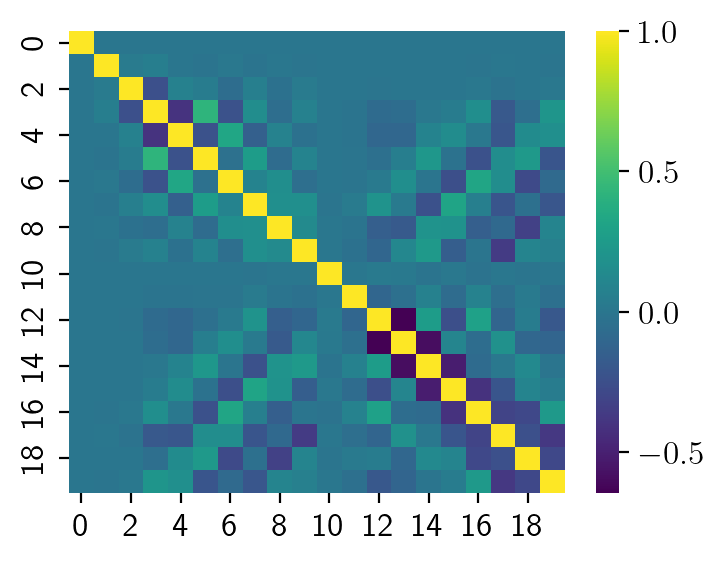

In [22]:
fig, ax = plt.subplots(figsize=(4.0, 3.0))
corr = bel_final.cov
corr = jnp.einsum("ij,ii,jj->ij", corr, 1/jnp.sqrt(corr), 1/jnp.sqrt(corr))
sns.heatmap(corr, cmap="viridis")

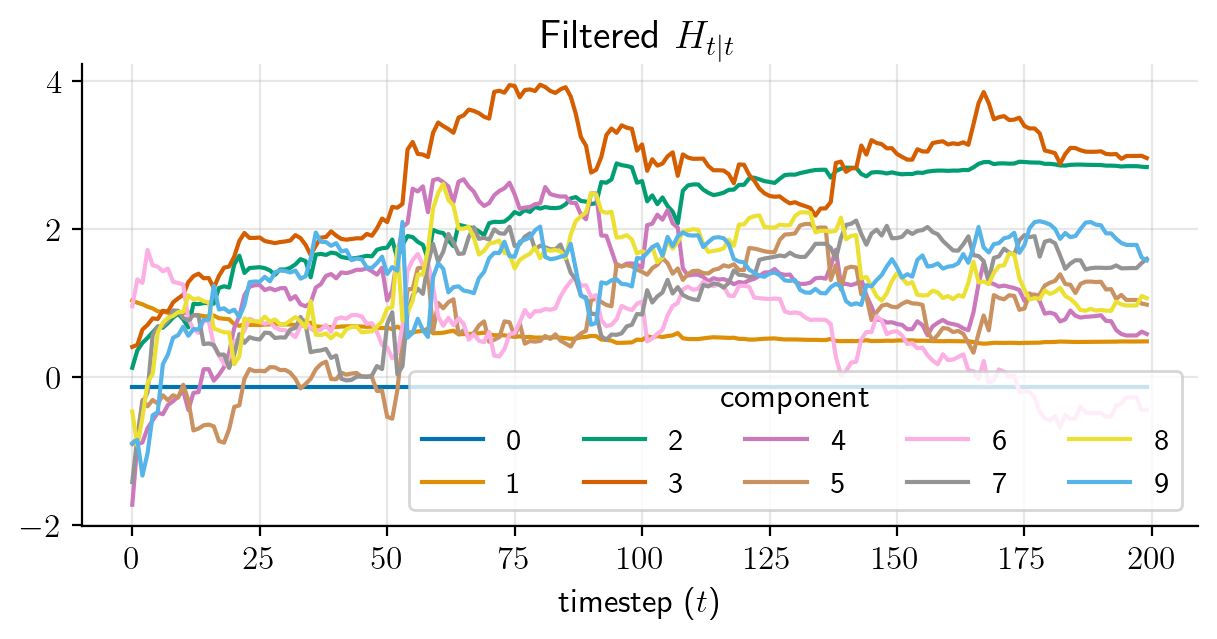

In [43]:
for i in range(10):
    plt.plot(hist_online["mu"][:, i], label=i)
plt.legend(ncol=5, title="component", fontsize=11)
plt.xlabel("timestep ($t$)")
plt.title(r"Filtered $H_{t|t}$")
plt.grid(alpha=0.3)
plt.savefig("online-ma-params.png", dpi=300, bbox_inches="tight")

In [44]:
jnp.sqrt(jnp.power(sample["y"] - hist_online["yhat"], 2).mean())

Array(1.9868741, dtype=float32)

In [45]:
jnp.sqrt(jnp.power(sample["y"] - hist_optimal["yhat"], 2).mean())

Array(1.6525016, dtype=float32)

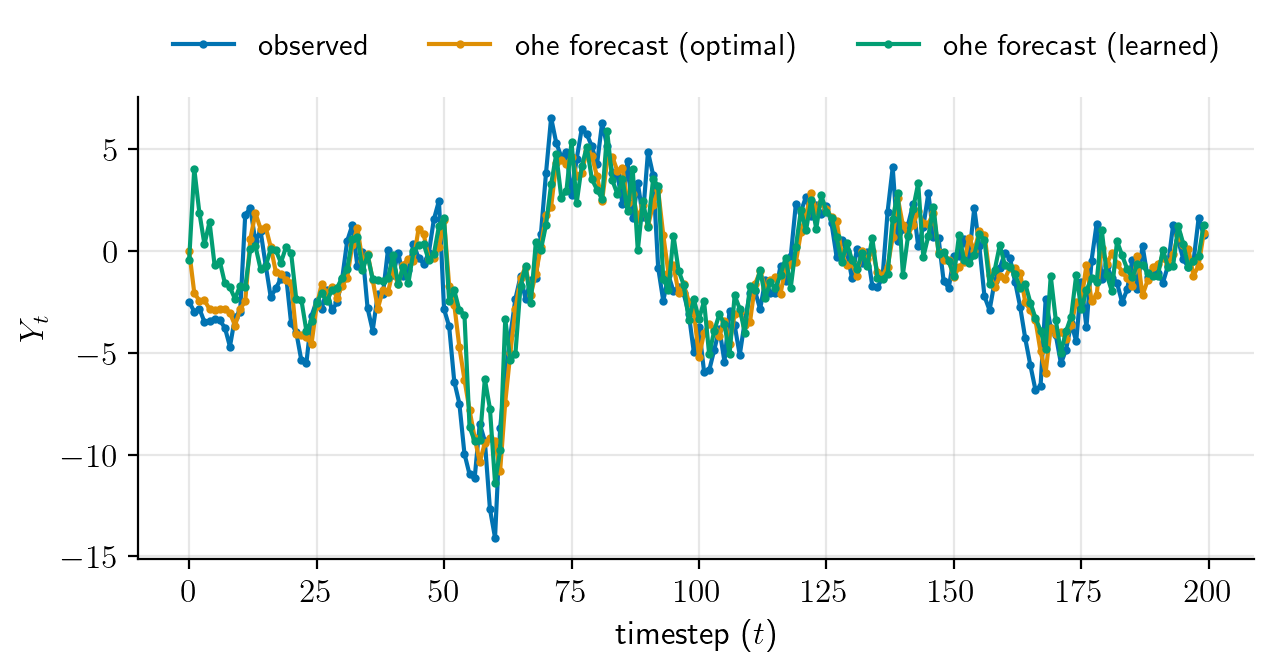

In [46]:
markersize = 0
plt.plot(sample["y"], marker="o", markersize=2, label="observed")
plt.plot(hist_optimal["yhat"], marker="o", markersize=2, label="ohe forecast (optimal)")
plt.plot(hist_online["yhat"], marker="o", markersize=2, label="ohe forecast (learned)")
plt.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.2), frameon=False, fontsize=11)
plt.xlabel("timestep ($t$)")
plt.ylabel("$Y_t$")
plt.grid(alpha=0.3)
plt.savefig("ma-m-ohe-forecast-comparison.png", dpi=300, bbox_inches="tight")

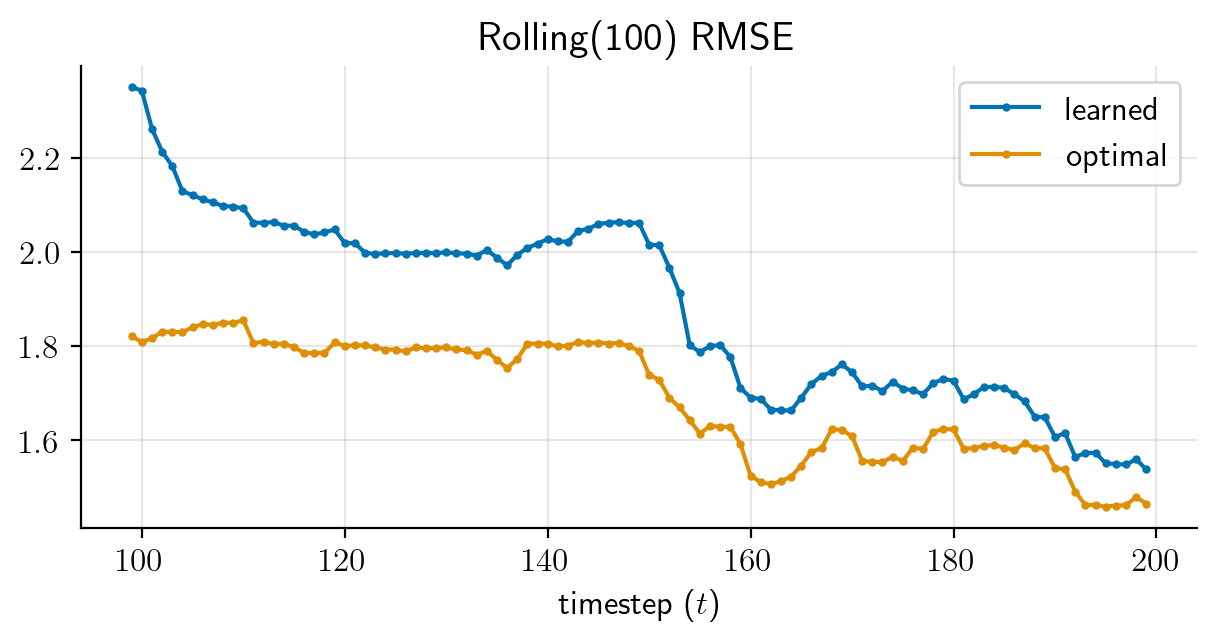

In [55]:
rmse_online = np.sqrt(pd.Series(jnp.power(sample["y"] - hist_online["yhat"], 2)).rolling(100).mean())
rmse_optimal = np.sqrt(pd.Series(jnp.power(sample["y"] - hist_optimal["yhat"], 2)).rolling(100).mean())

plt.plot(rmse_online, label="learned", marker="o", markersize=2)
plt.plot(rmse_optimal, label="optimal", marker="o", markersize=2)
plt.legend()
plt.title("Rolling(100) RMSE")
plt.xlabel("timestep ($t$)")
plt.grid(alpha=0.3)
plt.savefig("online-ma-rmse.png", dpi=300, bbox_inches="tight")

## Multi-step forecasting

In [56]:
@partial(jax.vmap, in_axes=1)
def corr_pair(y, yhat):
    return jnp.corrcoef(y, yhat + 1e-7)[0, 1]

In [57]:
k_rolls = jnp.arange(n_forecast + 1)
y_hist = sample["y"]
y_hist_forecast = jax.vmap(jnp.roll, in_axes=(None, 0), out_axes=-1)(y_hist, k_rolls)

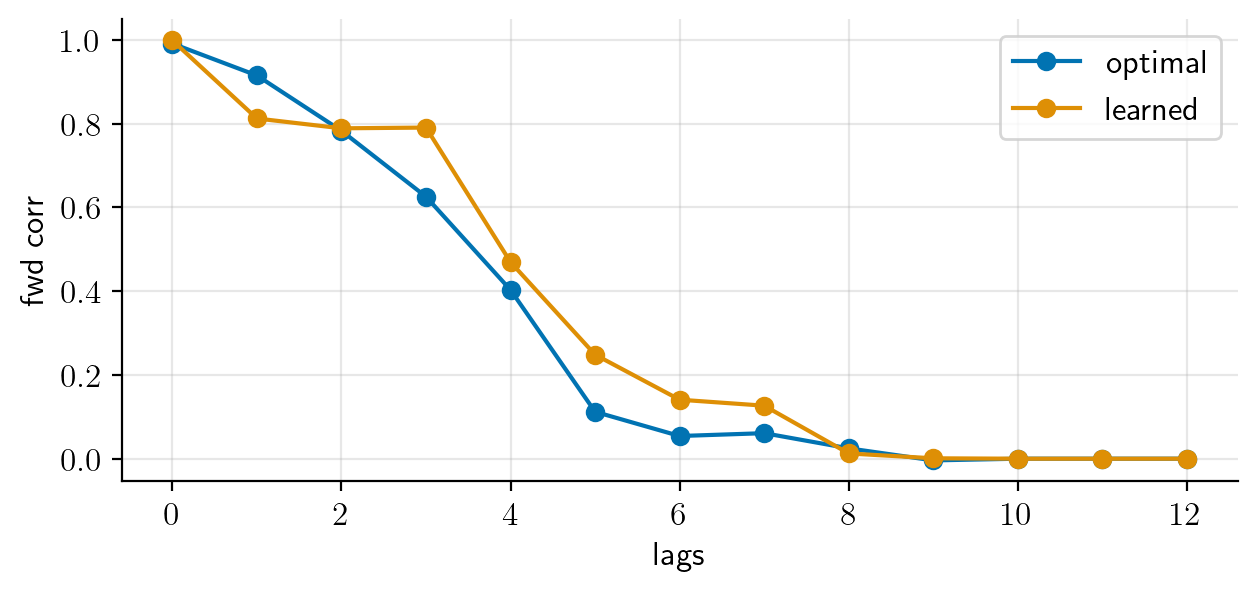

In [58]:
pred_ahead_optimal = hist_optimal["y_forecast"]
pred_ahead_online = hist_online["y_forecast"]

plt.plot(k_rolls, corr_pair(y_hist_forecast, pred_ahead_optimal), marker="o", label="optimal")
plt.plot(k_rolls, corr_pair(y_hist_forecast, pred_ahead_online), marker="o", label="learned")
plt.legend()
plt.xlabel("lags")
plt.ylabel("fwd corr")
plt.grid(alpha=0.3)
plt.savefig("online-ma-fwd-corr.png", dpi=300, bbox_inches="tight")

In [31]:
steps_ahead = jnp.arange(n_steps)[:, None] + jnp.arange(n_forecast + 1)[None, :]

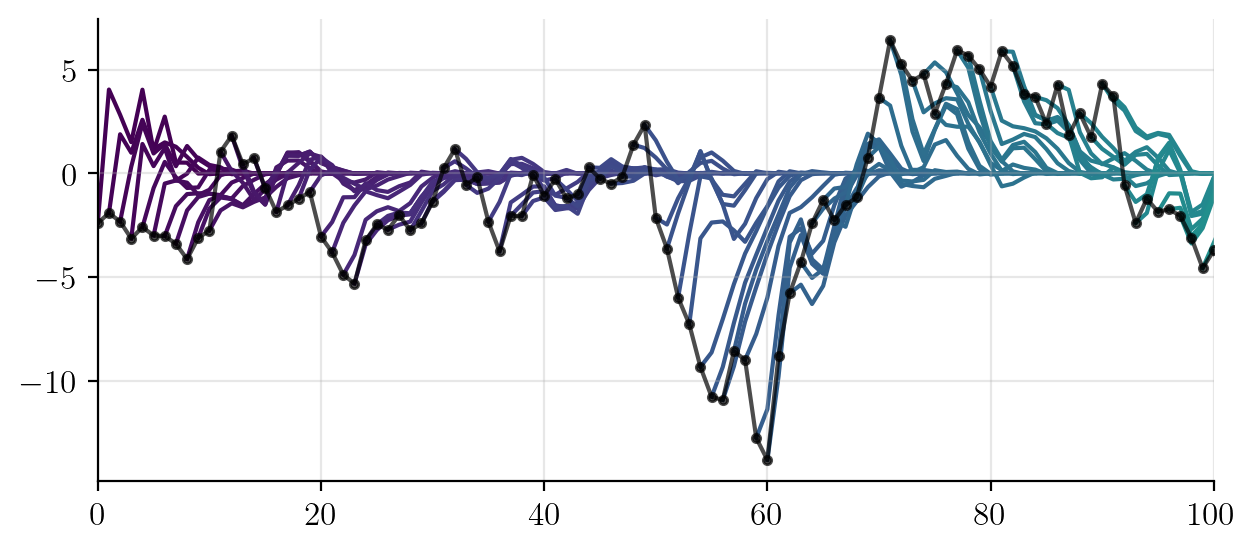

In [42]:
plt.plot(hist_online["y_corrected"], marker="o", markersize=3, label="one-step-ahead forecast", c="black", alpha=0.7)

colors = plt.cm.viridis(jnp.linspace(0, 1, n_steps))
for color, k_steps, k_pred in zip(colors, steps_ahead, pred_ahead_online):
    plt.plot(k_steps, k_pred, c=color, alpha=1.0, zorder=0)
plt.xlim(0, 100)
plt.grid(alpha=0.3)

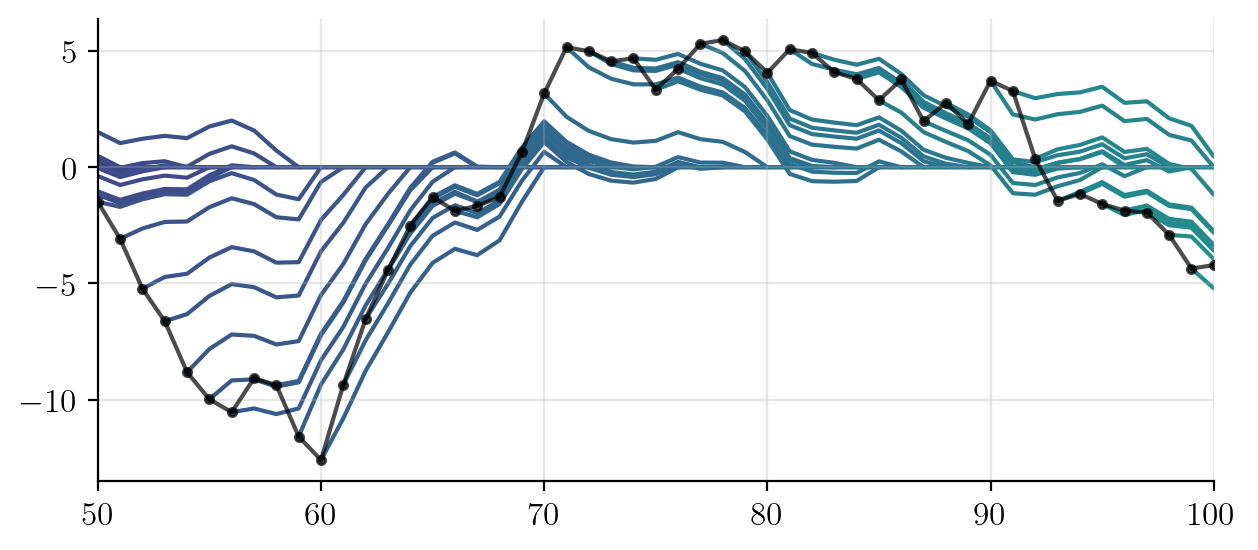

In [37]:
colors = plt.cm.viridis(jnp.linspace(0, 1, n_steps))
plt.plot(hist_optimal["y_corrected"], marker="o", markersize=3, label="one-step-ahead forecast", c="black", alpha=0.7)
colors = plt.cm.viridis(jnp.linspace(0, 1, n_steps))
for color, k_steps, k_pred in zip(colors, steps_ahead, pred_ahead_optimal):
    plt.plot(k_steps, k_pred, c=color, alpha=1.0, zorder=0)
# plt.xlim(0, 60)
plt.xlim(50, 100)
plt.grid(alpha=0.3)

# References
* Bell, Bradley M., and Frederick W. Cathey. "The iterated Kalman filter update as a Gauss-Newton method." IEEE Transactions on Automatic Control 38.2 (1993): 294-297.